In [1]:
import os
import logging

import pandas as pd
from tqdm import tqdm

# dev
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

In [2]:
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

---
### Questions ouvertes
  * Combien les batteries se sont détériorées ?
  
  * Comment détecter ce type d'erreurs ? Pourquoi ça arrive ? Est-ce qu'il faut lisser les courbes MacOS ?
    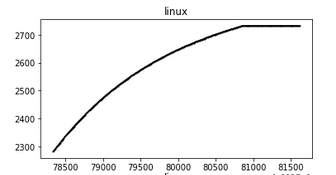 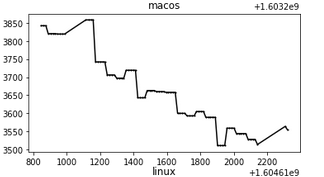 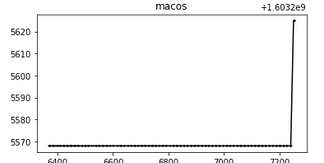  
  
  * Voir current_now pendant décharge/charge
  * Inspecter le `pd.DataFrame.describe()`
---

In [4]:
data = pd.read_csv("data_54.38.188.95/all.csv", index_col=0)

# Processing
data["fans_rpm"] = data["fans_rpm"].fillna(data["mean_fans_rpm"])
data.drop("mean_fans_rpm", axis=1)

data

,time,battery_status,manufacturer,os,uuid,cpu_speed,n_running_threads,cycle_count,ram_load,number_of_fans,...,voltage_min_design,cpu_temp,battery_temp,load_average_1,swap_load,mean_fans_rpm,charge_now,voltage_now,load_average_5,charge_full_design
0,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2681.984,1701.0,NaN,7869124.0,NaN,...,11400.0,54.0,NaN,1.60,36572.0,NaN,2760.0,12591.0,1.87,3684.0
1,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2918.897,1695.0,NaN,7553028.0,NaN,...,11400.0,59.0,NaN,2.11,36572.0,NaN,2760.0,12586.0,1.91,3684.0
2,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2908.592,1705.0,NaN,7660236.0,NaN,...,11400.0,59.0,NaN,2.18,36572.0,NaN,2760.0,12586.0,1.95,3684.0
3,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2883.110,1700.0,NaN,7603168.0,NaN,...,11400.0,56.0,NaN,2.28,36572.0,NaN,2760.0,12585.0,1.99,3684.0
4,1.601834e+09,Full,BYD,linux,5fbc9f85604740eb85dbf9dbd495de67,2867.058,1699.0,NaN,7610840.0,NaN,...,11400.0,59.0,NaN,2.21,36572.0,NaN,2760.0,12585.0,1.99,3684.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222840,1.605303e+09,Discharging,Simplo,linux,e18acda9486c41fc8d19777cd114ac39,NaN,1103.0,NaN,4600996.0,NaN,...,14400.0,NaN,NaN,NaN,10024.0,NaN,NaN,15250.0,NaN,NaN
222841,1.605303e+09,Full,BYD,linux,0a236299cff2433fbd19467990418ba4,NaN,NaN,NaN,8614844.0,NaN,...,11400.0,NaN,NaN,NaN,0.0,NaN,NaN,12565.0,NaN,NaN
222842,1.605303e+09,Discharging,Simplo,linux,e18acda9486c41fc8d19777cd114ac39,NaN,NaN,NaN,4590868.0,NaN,...,14400.0,NaN,NaN,NaN,10024.0,NaN,NaN,15263.0,NaN,NaN
222843,1.605303e+09,Full,BYD,linux,0a236299cff2433fbd19467990418ba4,NaN,NaN,NaN,NaN,NaN,...,11400.0,NaN,NaN,NaN,NaN,NaN,NaN,12564.0,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222845 entries, 0 to 222844
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time                222845 non-null  float64
 1   battery_status      222845 non-null  object 
 2   manufacturer        222845 non-null  object 
 3   os                  222845 non-null  object 
 4   uuid                222845 non-null  object 
 5   cpu_speed           91648 non-null   float64
 6   n_running_threads   222841 non-null  float64
 7   cycle_count         115218 non-null  float64
 8   ram_load            91656 non-null   float64
 9   number_of_fans      115223 non-null  float64
 10  current_now         222802 non-null  float64
 11  charge_full         222832 non-null  float64
 12  capacity            91644 non-null   float64
 13  load_average_15     220439 non-null  float64
 14  fans_rpm            201908 non-null  float64
 15  voltage_min_design  91657 non-null

In [6]:
data = data.loc[data["battery_status"].isin(["Charging", "Discharging"])]
data = data.sort_values(["time"])

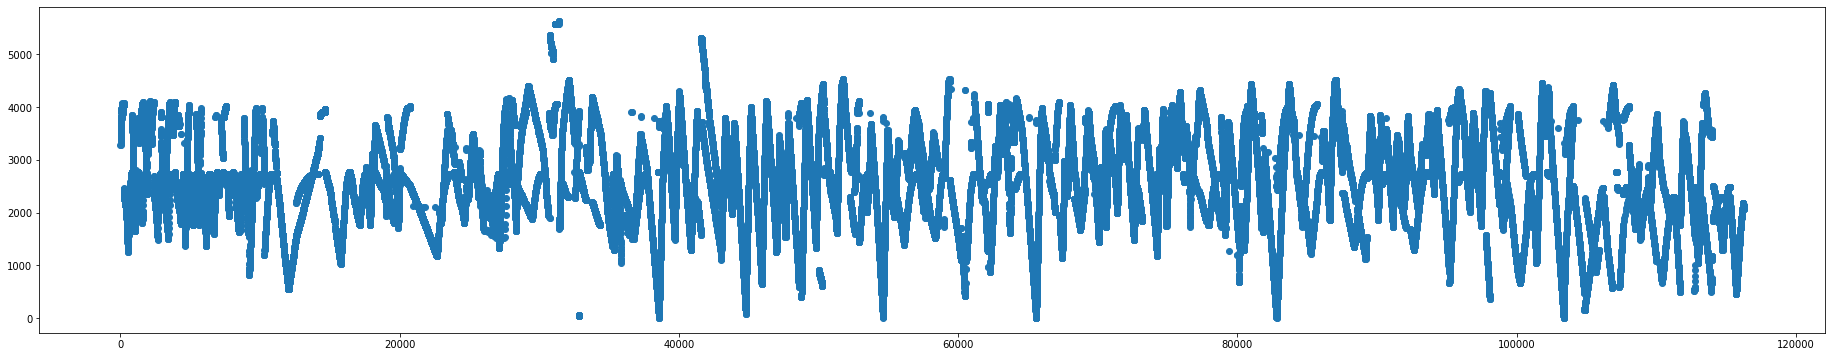

In [7]:
plt.figure(figsize=(32, 6))
plt.scatter([i for i in range(len(data))], data["charge_now"])

### Sessions

In [8]:
MAX_GAP_BETWEEN_SESSIONS = 400  # in seconds
MIN_NUM_POINTS_PER_SESSION = 10
MIN_SESSION_DURATION = 600 # in seconds

In [9]:
def extract_sessions(data):
    """Extract sessions.
    
    Args: 
        data (pd.DataFrame): data from one unique user (uuid 
            should be the same for all rows)
            
    Returns: 
        List of sessions (pd.Dataframes)
    """
    sessions = []

    logging.debug(f"{uuid} - {len(data)} points")

    while len(data) != 0:
        # Initialize some variables
        session = []
        status = data.iloc[0]["battery_status"]
        epoch = data.iloc[0]["time"]
        index = data.iloc[0].name
        session.append(data.iloc[0])

        # A session is ended with a:
        # * battery status change (from discharging to charging for eg)
        # * long enough gap between two consecutive data points
        for index_sess, row_sess in data[~data.index.isin([index])].iterrows():      
            last_index = index_sess
            if row_sess["battery_status"] != status:
                break
            elif row_sess["time"] - epoch > MAX_GAP_BETWEEN_SESSIONS:
                break
            else:
                session.append(row_sess)
            epoch = row_sess["time"]

        # Remove all rows that were processed
        data = data[data.index > last_index]
        # Add session if it's long enough (w.r.t time and # of points)
        if (len(session) > MIN_NUM_POINTS_PER_SESSION) and \
          (session[-1]["time"] - session[0]["time"]) > MIN_SESSION_DURATION:
            sessions.append(session)

    logging.debug(f"Extracted {len(sessions)} sessions")
    sessions_df = [pd.DataFrame(session) for session in sessions]
    return sessions_df

In [10]:
n_points = 0
sessions_df = []

for uuid in data["uuid"].unique():
    subsample = data[data["uuid"] == uuid]    
    n_points += len(subsample)
    sessions_df += extract_sessions(subsample)

print(f"{len(sessions_df)} sessions from {sum([len(sess) for sess in sessions_df])} points") 

DEBUG:root:13370f11455f4f36a0680b9725189375 - 18352 points
DEBUG:root:Extracted 81 sessions
DEBUG:root:5fbc9f85604740eb85dbf9dbd495de67 - 5649 points
DEBUG:root:Extracted 38 sessions
DEBUG:root:0a236299cff2433fbd19467990418ba4 - 31054 points
DEBUG:root:Extracted 93 sessions
DEBUG:root:6c328af026994ab5ae14d1eb27d92e2b - 54990 points
DEBUG:root:Extracted 189 sessions
DEBUG:root:73b12e7317274a1ea491b1a8b21d6eb0 - 1072 points
DEBUG:root:Extracted 3 sessions
DEBUG:root:e7bbfc496d57492a82e68d8cf2835761 - 16 points
DEBUG:root:Extracted 0 sessions
DEBUG:root:e18acda9486c41fc8d19777cd114ac39 - 5135 points
DEBUG:root:Extracted 21 sessions


425 sessions from 114285 points


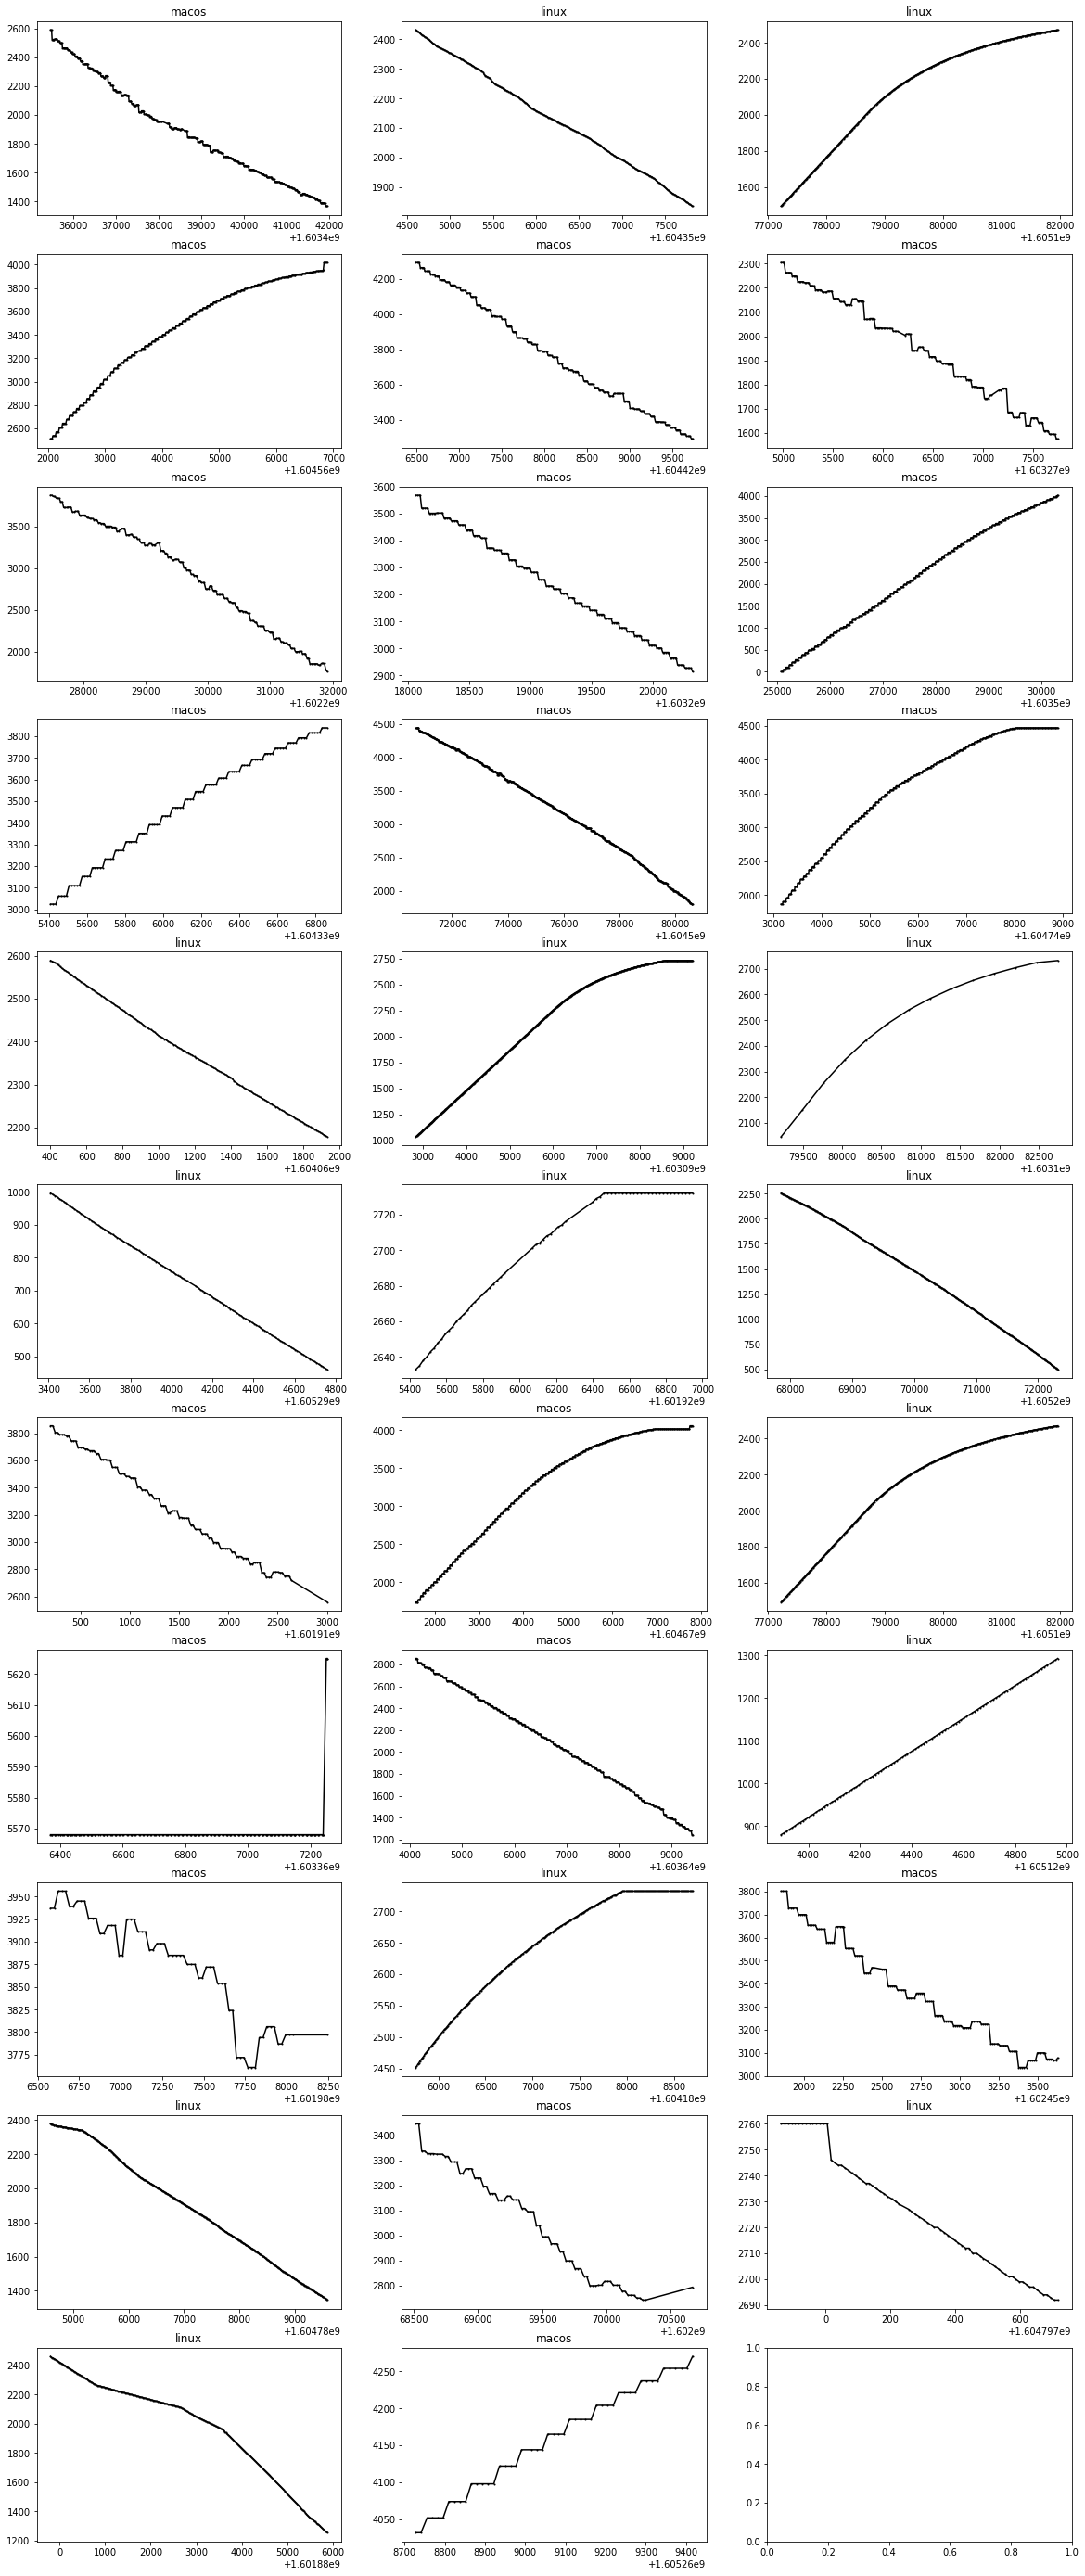

In [11]:
n = 32
row, col = np.unravel_index([i for i in range(n)], ((n // 3) + 1, 3))
choice = np.random.randint(0, len(sessions_df), n)
sessions_df = np.array(sessions_df, dtype=object)
fig, axes = plt.subplots((n // 3) + 1, 3, 
    figsize=(20, (n // 3)*5))

for i, session_df in enumerate(sessions_df[choice]):
    axes[row[i], col[i]].set_title(f"{session_df.iloc[0]['os']}")
    axes[row[i], col[i]].plot(session_df["time"], session_df["charge_now"], "ko-", markersize=1)

plt.show()

In [12]:
sessions_df[45]

,time,battery_status,manufacturer,os,uuid,cpu_speed,n_running_threads,cycle_count,ram_load,number_of_fans,...,voltage_min_design,cpu_temp,battery_temp,load_average_1,swap_load,mean_fans_rpm,charge_now,voltage_now,load_average_5,charge_full_design
128804,1.603364e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2534.0,167.0,NaN,2.0,...,NaN,48.19,33.09,1.85,NaN,0.0,3510.0,12307.0,1.74,5088.0
128808,1.603364e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2298.0,167.0,NaN,2.0,...,NaN,48.88,33.19,1.80,NaN,0.0,3510.0,12307.0,1.73,5088.0
128809,1.603364e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2248.0,167.0,NaN,2.0,...,NaN,50.06,33.30,1.91,NaN,0.0,3510.0,12307.0,1.76,5088.0
128810,1.603364e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2236.0,167.0,NaN,2.0,...,NaN,49.75,33.39,1.86,NaN,0.0,3510.0,12307.0,1.75,5088.0
128811,1.603364e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2224.0,167.0,NaN,2.0,...,NaN,50.44,32.50,1.89,NaN,0.0,3535.0,12557.0,1.76,5088.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129087,1.603367e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2193.0,167.0,NaN,2.0,...,NaN,52.25,36.39,1.52,NaN,0.0,4053.0,12704.0,1.54,5088.0
129090,1.603367e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2190.0,167.0,NaN,2.0,...,NaN,50.94,36.39,1.52,NaN,0.0,4053.0,12704.0,1.54,5088.0
129094,1.603367e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2180.0,167.0,NaN,2.0,...,NaN,50.75,36.39,1.39,NaN,0.0,4053.0,12704.0,1.51,5088.0
129099,1.603367e+09,Charging,SWD,macos,13370f11455f4f36a0680b9725189375,NaN,2180.0,167.0,NaN,2.0,...,NaN,50.56,36.39,1.31,NaN,0.0,4053.0,12704.0,1.49,5088.0


### Timeline

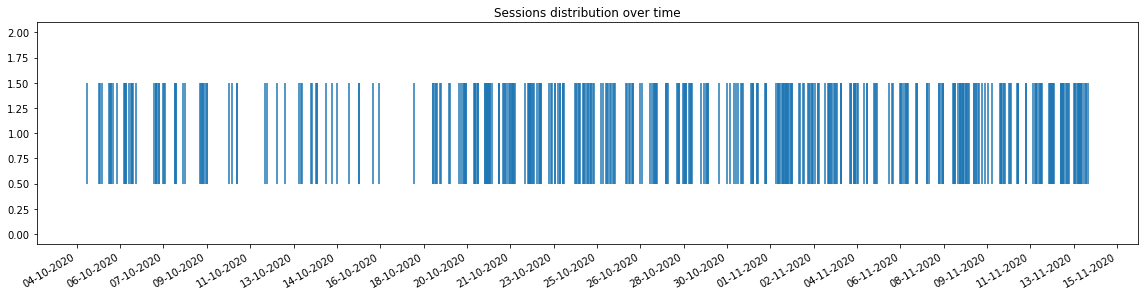

In [13]:
sessions_start = [session.iloc[0]["time"] for session in sessions_df]
plt.figure(figsize=(16, 4))
plt.eventplot(sessions_start)

# Inspired by:
# https://stackoverflow.com/questions/23294197/plotting-chart-with-epoch-time-x-axis-using-matplotlib
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_locator(mtick.FixedLocator(sessions_start))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))
plt.gca().xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda pos,_: time.strftime("%d-%m-%Y",time.localtime(pos)))
    )
plt.tight_layout()
plt.title("Sessions distribution over time")
plt.show()

### TSNE

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116268 entries, 91648 to 222844
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time                116268 non-null  float64
 1   battery_status      116268 non-null  object 
 2   manufacturer        116268 non-null  object 
 3   os                  116268 non-null  object 
 4   uuid                116268 non-null  object 
 5   cpu_speed           41849 non-null   float64
 6   n_running_threads   116266 non-null  float64
 7   cycle_count         61301 non-null   float64
 8   ram_load            41853 non-null   float64
 9   number_of_fans      61303 non-null   float64
 10  current_now         116238 non-null  float64
 11  charge_full         116261 non-null  float64
 12  capacity            41847 non-null   float64
 13  load_average_15     115193 non-null  float64
 14  fans_rpm            103084 non-null  float64
 15  voltage_min_design  41853 non-

In [15]:
features = [
    "battery_status",
    "manufacturer",
    "os",
    "uuid",
    "n_running_threads",
    "current_now",
    "charge_full",
    "load_average_15",
    "fans_rpm",
    "cpu_temp",
    "load_average_1",
    #"charge_now",
    "voltage_now",
    "load_average_5",
    #"charge_full_design",
]

extract = data[features].copy().dropna()

bs_dict = dict(enumerate(extract['battery_status'].astype("category").cat.categories))
battery_status = extract.pop("battery_status").astype("category").cat.codes

m_dict = dict(enumerate(extract['manufacturer'].astype("category").cat.categories))
manufacturer = extract.pop("manufacturer").astype("category").cat.codes

o_dict = dict(enumerate(extract['os'].astype("category").cat.categories))
os = extract.pop("os").astype("category").cat.codes

u_dict = dict(enumerate(extract['uuid'].astype("category").cat.categories))
uuid = extract.pop("uuid").astype("category").cat.codes

extract

,n_running_threads,current_now,charge_full,load_average_15,fans_rpm,cpu_temp,load_average_1,voltage_now,load_average_5
91648,2846.0,2053.0,4089.0,2.63,0.0,55.63,2.52,12527.0,2.64
91649,2837.0,2053.0,4089.0,2.62,0.0,59.44,2.45,12527.0,2.62
91650,2804.0,1863.0,4089.0,2.63,0.0,57.81,2.57,12547.0,2.63
91651,2794.0,1863.0,4089.0,2.66,0.0,57.63,2.99,12547.0,2.72
91652,2783.0,1863.0,4089.0,2.69,0.0,58.56,3.29,12547.0,2.81
...,...,...,...,...,...,...,...,...,...
91635,1112.0,1491.0,2300.0,1.71,3200.0,48.00,1.74,15334.0,1.81
91637,1109.0,1436.0,2300.0,1.73,3200.0,48.00,2.02,15306.0,1.87
91639,1109.0,1489.0,2300.0,1.74,3200.0,50.00,2.02,15303.0,1.87
91641,1107.0,1456.0,2300.0,1.72,3200.0,50.00,1.79,15291.0,1.83


In [33]:
from sklearn.manifold import TSNE

n = 2500
index = np.random.randint(0, len(extract), n)
data_embedded = TSNE(n_components=2).fit_transform(extract.iloc[index])

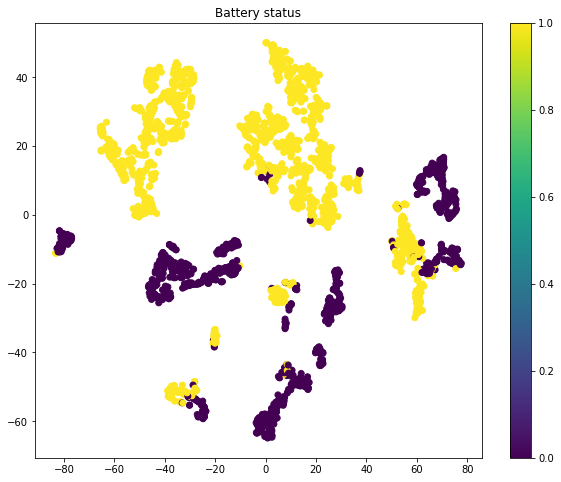

{0: 'Charging', 1: 'Discharging'}

In [34]:
plt.figure(figsize=(10, 8))
plt.title("Battery status")
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=battery_status.iloc[index])
plt.colorbar()
plt.show()
bs_dict

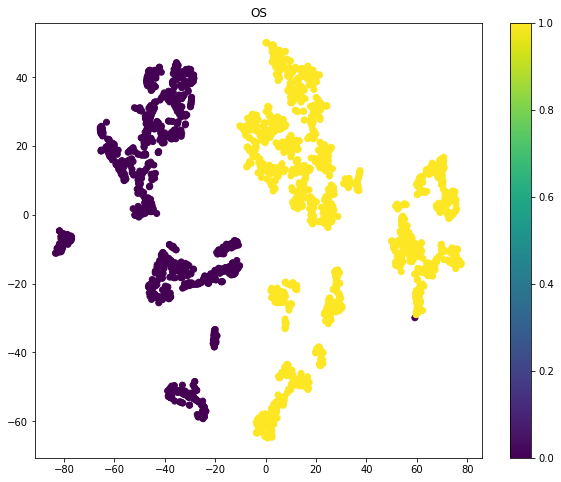

{0: 'linux', 1: 'macos'}

In [35]:
plt.figure(figsize=(10, 8))
plt.title("OS")
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=os.iloc[index])
plt.colorbar()
plt.show()
o_dict

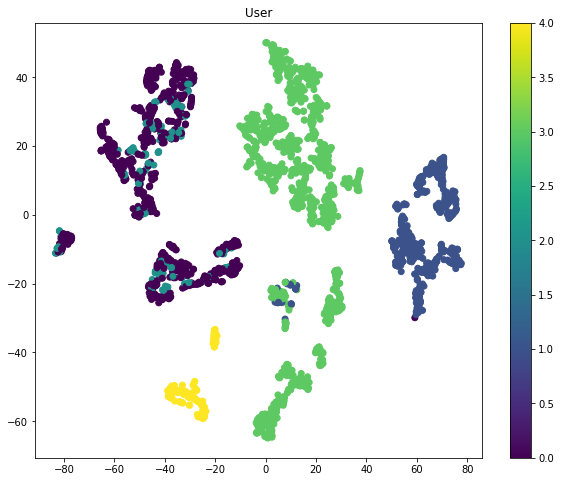

{0: '0a236299cff2433fbd19467990418ba4',
 1: '13370f11455f4f36a0680b9725189375',
 2: '5fbc9f85604740eb85dbf9dbd495de67',
 3: '6c328af026994ab5ae14d1eb27d92e2b',
 4: 'e18acda9486c41fc8d19777cd114ac39'}

In [36]:
plt.figure(figsize=(10, 8))
plt.title("User")
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=uuid.iloc[index])
plt.colorbar()
plt.show()
u_dict